In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

In [3]:
def showImg(img, colored=False):
    plt.figure(figsize=(20,20))
    plt.axis("off")
    if (len(img.shape) == 3):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    elif(colored):
        plt.imshow(img)
    else:
        plt.imshow(img, 'gray')

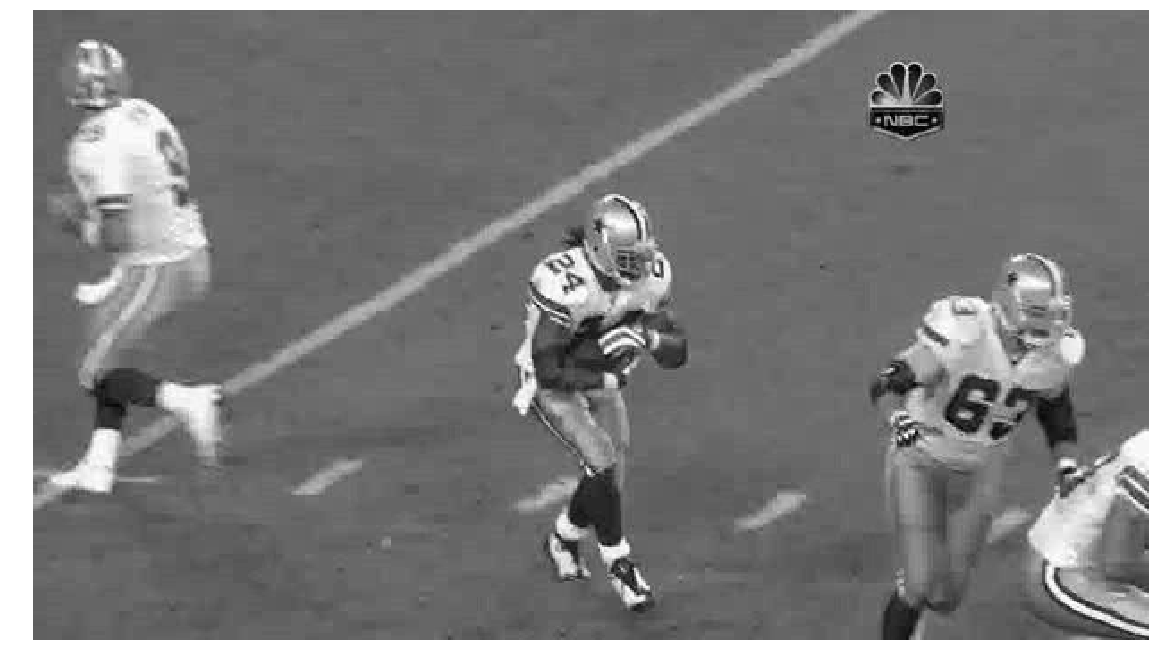

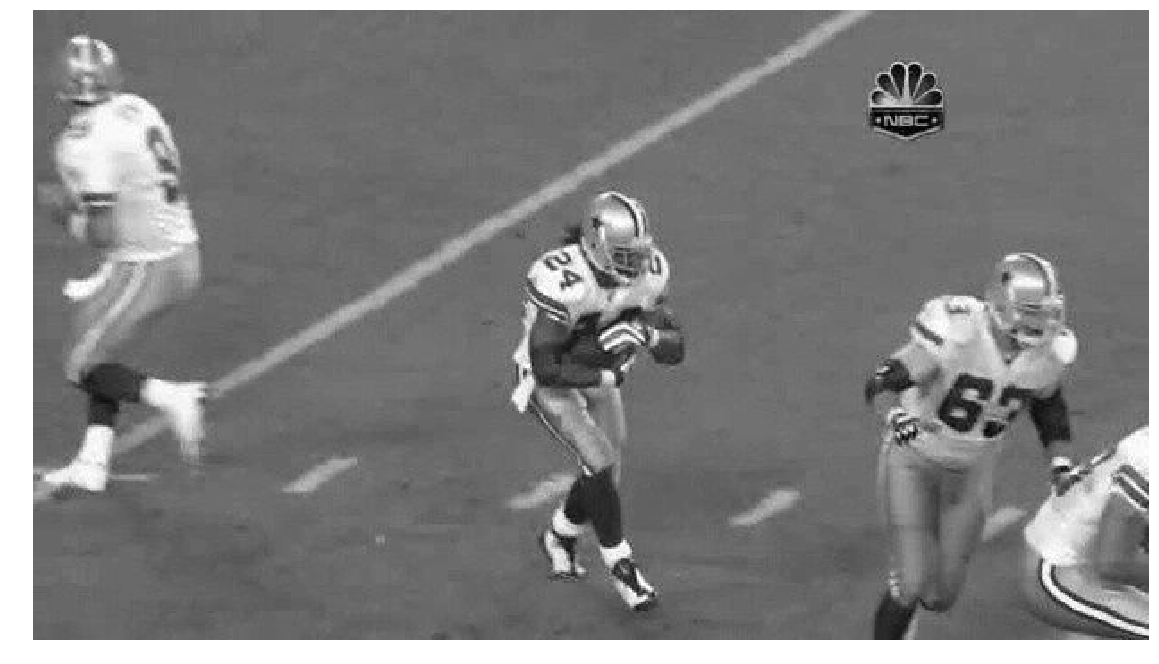

In [13]:
img1 = cv2.imread("1.jpg", 0)
img2 = cv2.imread("2.jpg", 0)

showImg(img1)
showImg(img2)

(352, 624)
(352, 624)


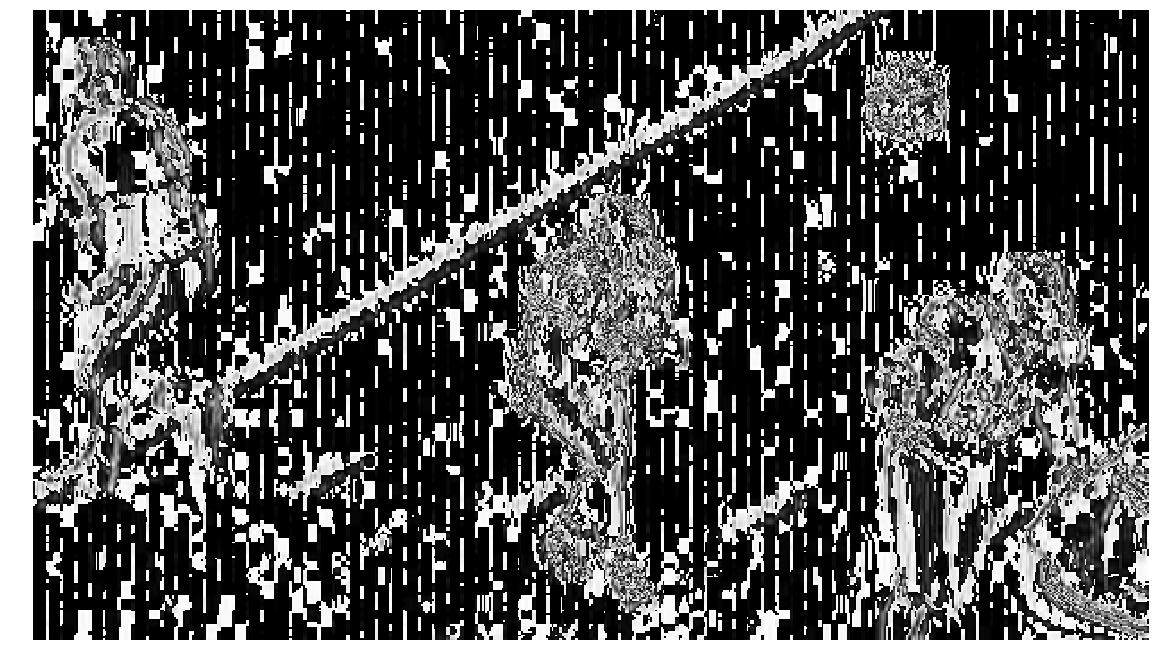

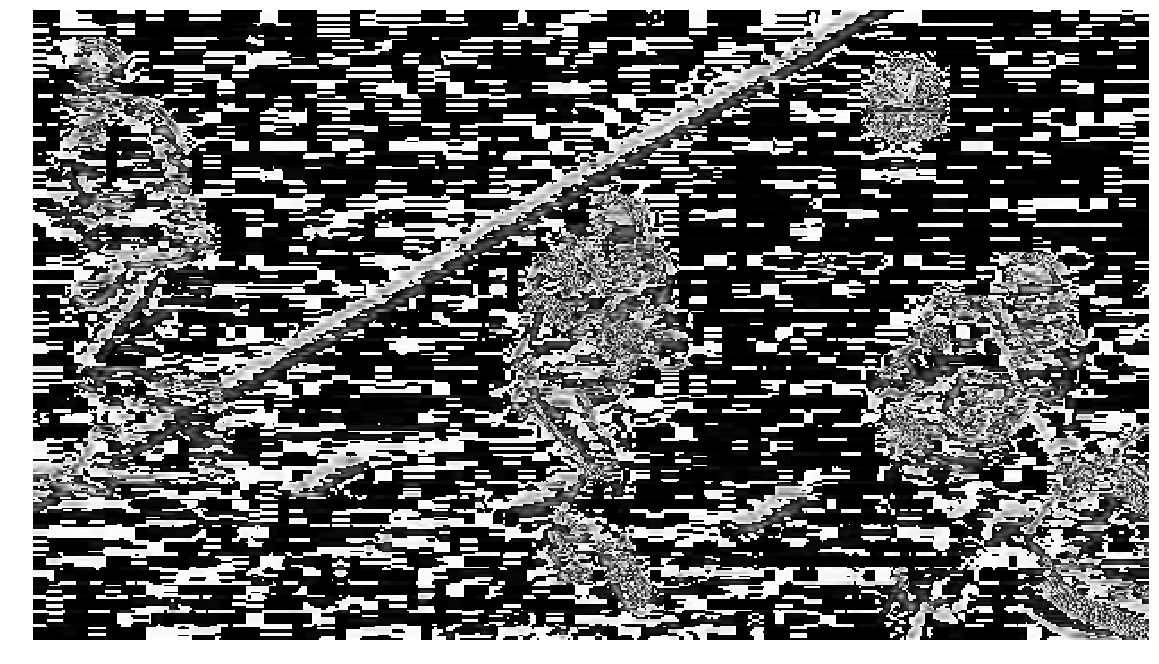

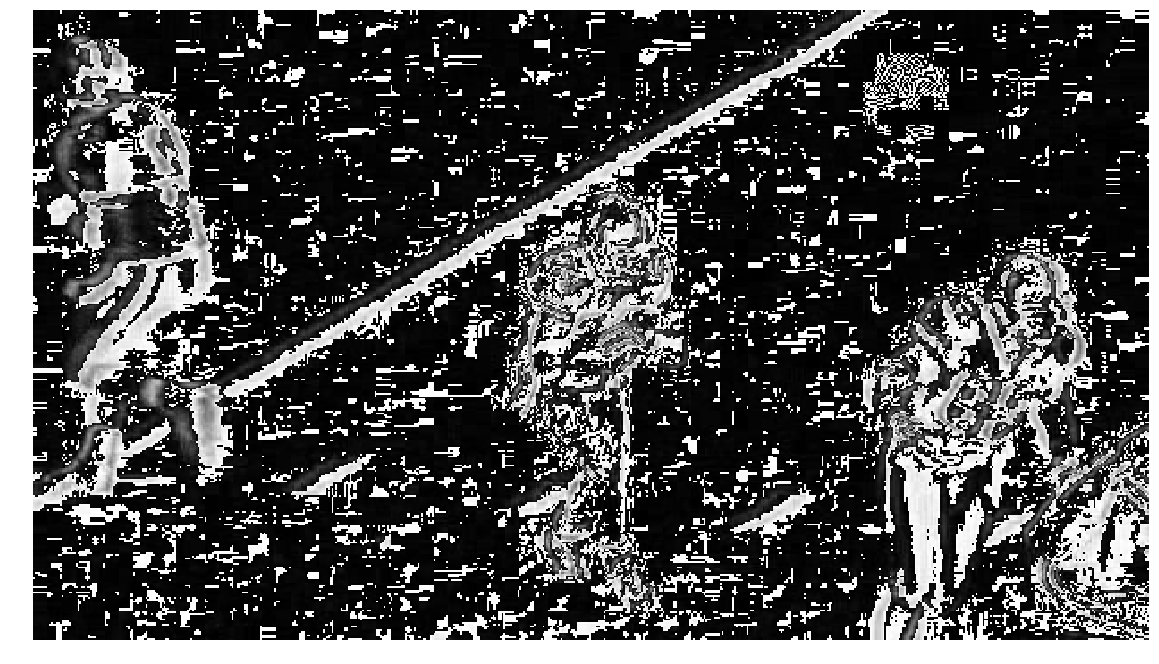

In [14]:
horizintalKernel = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1],
])
verticalKernel = np.array([
    [-1, -1,  -1],
    [0,   0,   0],
    [1,   1,   1],
])

# def optical_flow(Ix, Iy, windowSize=3):
Ix = ndimage.convolve(img1, horizintalKernel)
Iy = ndimage.convolve(img1, verticalKernel)
It = img2 - img1

print(img1.shape)
print(Ix.shape)
showImg(Ix)
showImg(Iy)
showImg(It)